<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/spectra_search_allsilicone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v2.0(current): spectra for all-silicone meta material.

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

Mounted at /content/drive


# Change Working Directory

In [ ]:
import os

path = '/content/drive/My Drive/BU Class/Research/BioDL_Project'
os.chdir(path)
os.listdir(path)

print('DONE')

DONE


# Prepare Pseudo Data

## Model Construction

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out

In [ ]:
class NetDense(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetDense, self).__init__()
        self.dim_out = dim_out

        self.tksz1d1 = 20
        self.dim_mid1 = 500  # dimension in the middle before conv layer

        self.fc = nn.Sequential(
        nn.Linear(dim_in, 50),
        nn.ReLU(True),
        nn.Linear(50, 100),
        nn.ReLU(True),
        nn.Linear(100, 200),
        nn.ReLU(True),
        nn.Linear(200, self.dim_mid1-self.tksz1d1+1),
        nn.ReLU(True),
        )

        self.convt1 = nn.Sequential(
            nn.ConvTranspose1d(1, 4, kernel_size=self.tksz1d1, stride=1),
            nn.BatchNorm1d(4),
            nn.ReLU(True),
        )

        self.fc_sampling1 = nn.Sequential(
        nn.Linear(self.dim_mid1, 1000),
        nn.ReLU(True),
        nn.Linear(1000, 1500),
        nn.ReLU(True),
        # nn.Dropout(p=0.2),  # drop out layer
        nn.Linear(1500, self.dim_out),
        )

    def forward(self, x):
        out = self.fc(x)
        out = out.view(out.shape[0], 1, -1)
        out = self.convt1(out)
        out = self.fc_sampling1(out)

        # out = out.view(out.shape[0], 2, -1)

        return out

## Load Trained Model

In [ ]:
PATH_MODEL = './model/v1_5/netdeconv_allsilicone3212_E3000.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_dense = NetDense(16,1001)
net_dense.load_state_dict(torch.load(PATH_MODEL))
# net_dense = torch.load(PATH_MODEL)
net_dense = net_dense.to(device)
net_dense.eval()

print('MODEL LOADED')
print(device)

MODEL LOADED
cuda:0


## Predict Spectra from Pseudo Params

With trained network, we can generate more predicted spectra corresponding to pseudo design parameters, and zip the as a "pseudo dataset", then perform searching of the target spectra response on it.

In [ ]:
def generate_pseudo_params(params_range):
    '''
    Generate pseudo params.
    params_range: [[range1 for D1], [range2 for D2]], a list, each entry is a list consist:
                  [range_start, range_end, step_size].
    '''

    for idx_params, params in enumerate(itertools.product(*[range(*ele_range) for ele_range in params_range])):
        # print('params:', params)
        # print('params.shape:', np.array(params).shape)
        params = np.array(params)[np.newaxis, ...]
        # print('params.shape:', np.array(params).shape)
        if idx_params == 0:
            pseudo_params = params
        else:
            pseudo_params = np.concatenate((pseudo_params, params), axis=0)
    return pseudo_params

def generate_pseudo_data(pseudo_params, net, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False):
    '''
    Generate pseudo data with trained network.
    pseudo_params: numpy array.
    net: trained network.
    device: torch available device.
    PATH_pseudo_dataset: path to save pseudo dataset.
    flag_save_pseudo_data: 'True' to save pseudo data.
    '''

    # params as torch tensor
    X = torch.tensor(pseudo_params).float().to(device)
    net = net.to(device)
    net.eval()

    # input to model and get spectra
    y_pred = net(X)
    y_pred_np = y_pred.cpu().detach().numpy()  # predicted spectra
    if flag_save_pseudo_data:
        np.savez(PATH_pseudo_dataset, params=pseudo_params, spectra=y_pred_np)
        print('Pseudo data saved')
        
    return pseudo_params, y_pred_np

### Visualize Training Data Range

In [ ]:
# Parameters = {p1=70; p2=70; p3=70; p4=70; p5=70; p6=70; phi=0(X); px=346.4; py=200; 
#         r1=10; r2=10; r3=10; r4=10; r5=10; r6=10; r7=10; t_pattern=61; theta=0(X)}
path_dataset = './data/allsilicone_r1r2r7_3212.npz'

data = np.load(path_dataset)


param = data['param']
spectra_R1 = data['R1'][...,1]  #[N,1001]
spectra_T1 = data['T1'][...,1]
spectra_R2 = data['R2'][...,1]
spectra_T2 = data['T2'][...,1]

# select param, reduce spectra dim
idx_pick_param = [0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16]
param = param[...,idx_pick_param]


spectra_R1 = np.expand_dims(spectra_R1, 1)  #[N,1,1001]
spectra_T1 = np.expand_dims(spectra_T1, 1)
spectra_R2 = np.expand_dims(spectra_R2, 1)
spectra_T2 = np.expand_dims(spectra_T2, 1)
spectra_RT = np.concatenate((spectra_R1,spectra_R2,spectra_T1,spectra_T2), axis=1)
print('param.shape:', param.shape)
print('spectra_RT.shape', spectra_RT.shape)
print('----------------')


# Show params ranges in training data
for i in range(6):
    print('p %d' %(i+1))
    # print(np.max(param[...,i]))
    # print(np.min(param[...,i]))
    print(np.unique(param[...,i]))
    print('------')

for i in range(7):
    print('r %d' %(i+1))
    # print(np.max(param[...,i+8]))
    # print(np.min(param[...,i+8]))
    print(np.unique(param[...,i+8]))
    print('------')

param.shape: (3212, 16)
spectra_RT.shape (3212, 4, 1001)
----------------
p 1
[10. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46.
 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68. 70.]
------
p 2
[30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64.
 66. 68. 70.]
------
p 3
[70.]
------
p 4
[70.]
------
p 5
[70.]
------
p 6
[70.]
------
r 1
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44.
 46. 48. 50.]
------
r 2
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44.
 46. 48. 50.]
------
r 3
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
------
r 4
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
------
r 5
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
------
r 6
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
------
r 7
[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
------


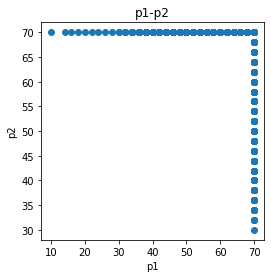

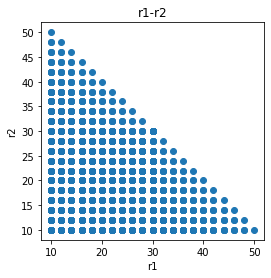

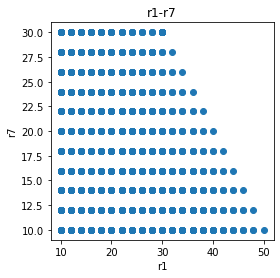

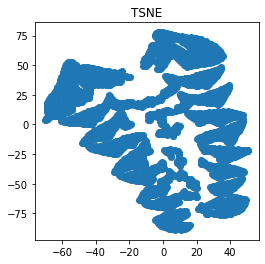

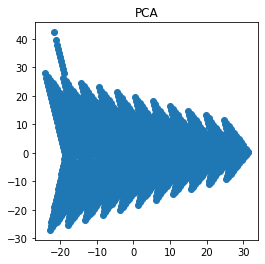

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.figure(1, figsize=(4,4))
plt.title('p1-p2')
plt.xlabel('p1')
plt.ylabel('p2')
plt.scatter(param[:,0], param[:,1])  # p1-p2

plt.figure(2, figsize=(4,4))
plt.title('r1-r2')
plt.xlabel('r1')
plt.ylabel('r2')
plt.scatter(param[:,8], param[:,9])  # r1-r2

plt.figure(3, figsize=(4,4))
plt.title('r1-r7')
plt.xlabel('r1')
plt.ylabel('r7')
plt.scatter(param[:,8], param[:,14])  # r1-r7

# TSNE
param_embedded = TSNE(n_components=2).fit_transform(param)
plt.figure(4, figsize=(4,4))
plt.title('TSNE')
plt.scatter(param_embedded[:,0], param_embedded[:,1])

# PCA
param_embedded = PCA(n_components=2).fit_transform(param)
plt.figure(5, figsize=(4,4))
plt.title('PCA')
plt.scatter(param_embedded[:,0], param_embedded[:,1])

### Generate Pseudo Params and Visualize the Range

Typically, we generate a "pseudo-dataset" within the range of the training data with a much denser sampling frequency.

In [ ]:
# Parameters = {p1=70; p2=70; p3=70; p4=70; p5=70; p6=70; phi=0(X); px=346.4; py=200; 
#         r1=10; r2=10; r3=10; r4=10; r5=10; r6=10; r7=10; t_pattern=61; theta=0(X)}
step_r = 1

r1 = [10,51,step_r]
r2 = [10,51,step_r]
r_else = [10,31,step_r]

params_range = [r_else]
v_r1 = r1[0]
v_r2 = r2[0]
v_p = 70.
count = 0
for [v_r_else] in itertools.product(*[range(*ele_range) for ele_range in params_range]):
    while v_r1 <= v_p-10-v_r_else and v_r1<r1[1]:
        while v_r2 <= v_p-10-v_r_else and v_r2<r2[1]:
            if v_r1+v_r2<=v_p-10:
                params = np.array([v_p,v_p,70.,70.,70.,70.,346.4,200.,
                        v_r1,v_r2,v_r_else,v_r_else,v_r_else,v_r_else,v_r_else,
                        61.])[np.newaxis, ...]
                if count == 0:
                    pseudo_params = params
                else:
                    pseudo_params = np.concatenate((pseudo_params, params), axis=0)
                count += 1

            v_r2 += r2[2]
        v_r2 = r2[0]
        v_r1 += r1[2]
    v_r1 = r1[0]



print('count:', count)
print('pseudo_params.shape:', pseudo_params.shape)
print('----------------')

count: 15001
pseudo_params.shape: (15001, 16)
----------------


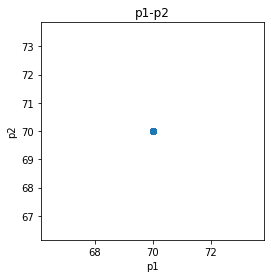

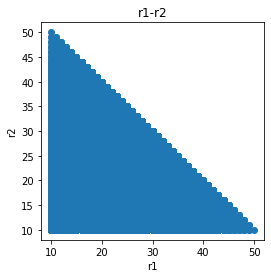

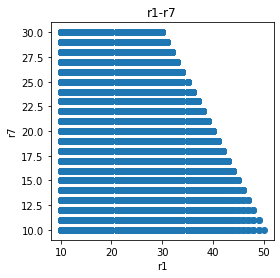

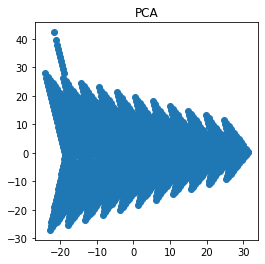

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.figure(1, figsize=(4,4))
plt.title('p1-p2')
plt.xlabel('p1')
plt.ylabel('p2')
plt.scatter(pseudo_params[:,0], pseudo_params[:,1])  # p1-p2

plt.figure(2, figsize=(4,4))
plt.title('r1-r2')
plt.xlabel('r1')
plt.ylabel('r2')
plt.scatter(pseudo_params[:,8], pseudo_params[:,9])  # r1-r2

plt.figure(3, figsize=(4,4))
plt.title('r1-r7')
plt.xlabel('r1')
plt.ylabel('r7')
plt.scatter(pseudo_params[:,8], pseudo_params[:,14])  # r1-r7

# TSNE
# pseudo_params_embedded = TSNE(n_components=2).fit_transform(pseudo_params)
# plt.figure(4, figsize=(4,4))
# plt.title('TSNE')
# plt.scatter(pseudo_params_embedded[:,0], pseudo_params_embedded[:,1])  # r1-r7

param_embedded = PCA(n_components=2).fit_transform(param)
plt.figure(4, figsize=(4,4))
plt.title('PCA')
plt.scatter(param_embedded[:,0], param_embedded[:,1])

### Generate Pseudo Dataset

Get predicted spectra with trained network and pseudo design params and generate pseudo dataset: (pseudo_params, pseudo_spectra)

In [ ]:
pseudo_params, pseudo_spectra = generate_pseudo_data(pseudo_params, net_dense, device)
print(pseudo_params.shape)
print(pseudo_spectra.shape)

(15001, 16)
(15001, 4, 1001)


# Spectra Search from Pseudo Data

## Set Target Data

(30,)
(30,)
Target Design Params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   44.   10.   10.   10.
  10.   10.   10.   61. ]


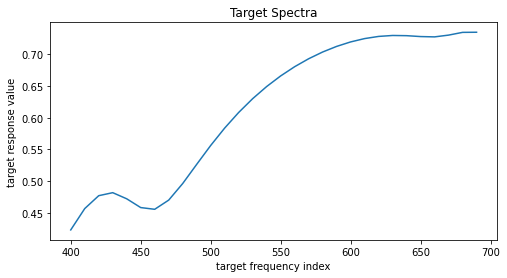

In [ ]:
# set target data
idx_sample = 17

tg_idx_freq = np.arange(400,700,10)  # debug use
# tg_idx_freq = np.arange(1001)  # debug use
print(tg_idx_freq.shape)

idx_tg_spectra = 0
tg_value = spectra_RT[idx_sample,idx_tg_spectra,tg_idx_freq]
print(tg_value.shape)

plt.figure(1, figsize=(8,4))
plt.title('Target Spectra')
plt.xlabel('target frequency index')
plt.ylabel('target response value')
plt.plot(tg_idx_freq, tg_value)  # tg_idx-tg_value

tg_params = param[idx_sample]
print('Target Design Params:', tg_params)

## Perform Norm Search

$p^* = argmin_{p\in D}\frac{1}{N}\sum_{i=1}^{N} d(s_i(p),t_i)$

where $s_i(p)$ is the spectra response at frequency index $i$, with design parameter $p$; $D$ is pseudo design parameter-spectra dataset; $t_i$ is the target response at frequency index $i$.

In [ ]:
spectra_dict = pseudo_spectra[:,0,tg_idx_freq]
print('spectra_dict.shape:', spectra_dict.shape)

dist = np.linalg.norm(spectra_dict-tg_value, ord=2, axis=-1)/spectra_dict.shape[-1]  # distance calculation
print('dist.shape:', dist.shape)
print('dist:', dist)
print('min dist', min(dist))

idx_sorted = np.argsort(dist)
print('idx_sorted', idx_sorted)

spectra_dict.shape: (15001, 30)
dist.shape: (15001,)
dist: [0.01727923 0.01700666 0.01671468 ... 0.07954053 0.08019925 0.08048509]
min dist 0.00034896656571126465
idx_sorted [  833   826   819 ... 14979 14999 15000]


In [ ]:
N_top = 5  # pick fisrt several idx
idx_pick = idx_sorted[0:N_top]
print('idx picked:', idx_pick)

dist_pick = dist[idx_pick,...]  # distance
params_pick = pseudo_params[idx_pick,...]  # picked param
spectra_pick = pseudo_spectra[idx_pick,...]
print('dist_pick.shape:', dist_pick.shape)
print('params_pick.shape:', params_pick.shape)
print('spectra_pick.shape:', spectra_pick.shape)

print('params_pick:', params_pick)

idx picked: [833 826 819 818 810]
dist_pick.shape: (5,)
params_pick.shape: (5, 16)
spectra_pick.shape: (5, 4, 1001)
params_pick: [[ 70.   70.   70.   70.   70.   70.  346.4 200.   44.   10.   10.   10.
   10.   10.   10.   61. ]
 [ 70.   70.   70.   70.   70.   70.  346.4 200.   43.   11.   10.   10.
   10.   10.   10.   61. ]
 [ 70.   70.   70.   70.   70.   70.  346.4 200.   42.   13.   10.   10.
   10.   10.   10.   61. ]
 [ 70.   70.   70.   70.   70.   70.  346.4 200.   42.   12.   10.   10.
   10.   10.   10.   61. ]
 [ 70.   70.   70.   70.   70.   70.  346.4 200.   41.   14.   10.   10.
   10.   10.   10.   61. ]]


## Visualize Picked Spectra

Target Design Params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   44.   10.   10.   10.
  10.   10.   10.   61. ]
Top 1 best match, picked params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   44.   10.   10.   10.
  10.   10.   10.   61. ]


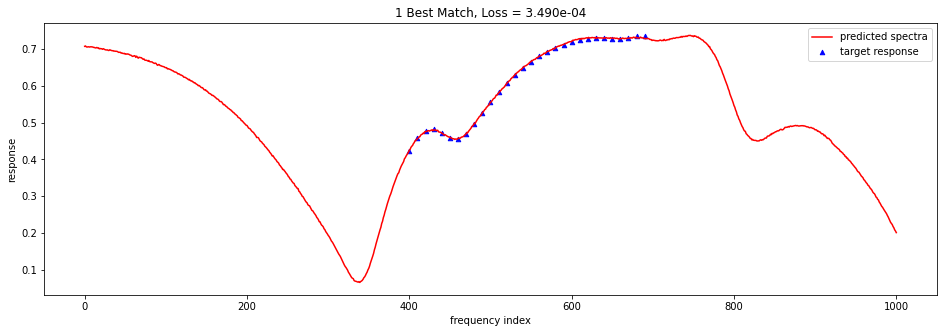

----
Top 2 best match, picked params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   43.   11.   10.   10.
  10.   10.   10.   61. ]


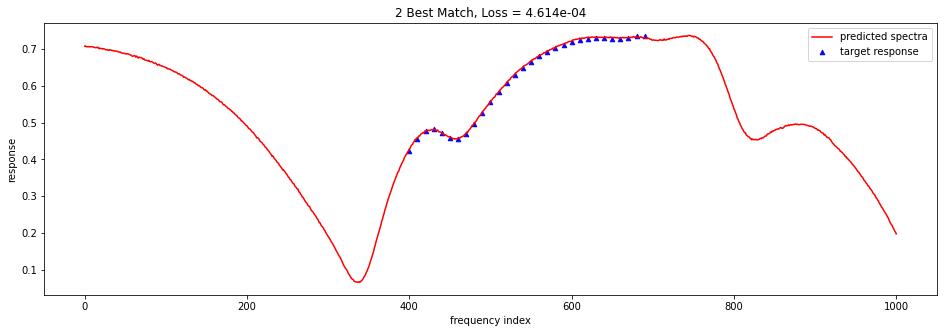

----
Top 3 best match, picked params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   42.   13.   10.   10.
  10.   10.   10.   61. ]


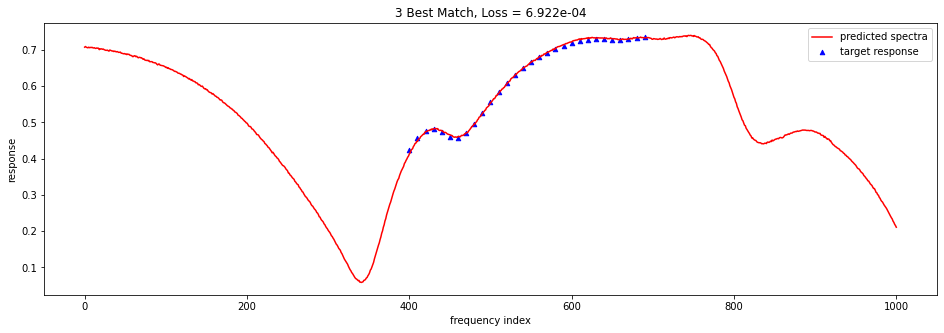

----
Top 4 best match, picked params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   42.   12.   10.   10.
  10.   10.   10.   61. ]


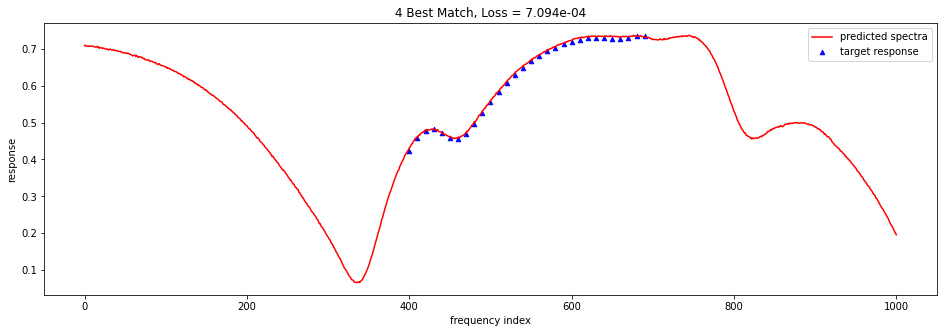

----
Top 5 best match, picked params: [ 70.   70.   70.   70.   70.   70.  346.4 200.   41.   14.   10.   10.
  10.   10.   10.   61. ]


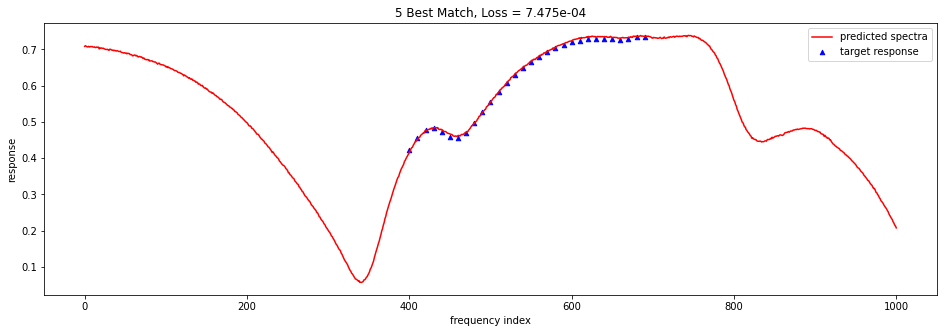

----


In [ ]:
print('Target Design Params:', tg_params)
plt.ion()  # interactive plt while looping
for idx_fig in range(params_pick.shape[0]):
    # get params
    print('Top', idx_fig+1, 'best match, picked params:', params_pick[idx_fig])
    # plot spectra
    plt.figure(idx_fig+1, figsize=(16,5))
    plt.title(str(idx_fig+1)+' Best Match, Loss = '+'{:.3e}'.format(dist_pick[idx_fig]))
    plt.xlabel('frequency index')
    plt.ylabel('response')
    plt.plot(np.arange(spectra_pick.shape[-1]), spectra_pick[idx_fig,idx_tg_spectra,:], c='r')
    plt.scatter(tg_idx_freq, tg_value, c='b', marker='^', s=20)
    plt.legend(('predicted spectra', 'target response'))

    plt.savefig('./figs/spectra_search_result'+str(idx_fig+1)+'.png', bbox_inches='tight', dpi=300)
    # for idx_subfig in range(4):
    #     plt.suptitle(str(idx_fig+1)+' th BEST')
    #     plt.subplot(4, 1, idx_subfig+1)
    #     plt.plot(np.arange(spectra_pick.shape[-1]), spectra_pick[idx_fig,idx_subfig,:], c='r')
    #     if idx_subfig==0:
    #         plt.scatter(tg_idx_freq, tg_value, c='b', marker='^', s=200)
    plt.show()
    print('----')
plt.ioff()